# Basic classification modeling example

This Notebook will walk through building a logistic regression using Sklearn to predict a binary outcome, with appropriate data exploration and model plotting. It makes use of re-usable functions for various data and model exploration capabilities stored within .py files in the /utilities/ folder.

If you are new to regression and classification modeling, we recommend that you first look at the regression modeling notebook as some concepts are explained in more detail there. 

**Table of contents**

- **<a href="#data_import_overview">Data import and overview</a>**
- **<a href="#bivariate_exploration">Bivariate exploration</a>**
	- <a href="#correlation_analysis">Correlation analysis amd scatterplots</a>
	- <a href="#barplots">Barplots and box-and-whisker plots</a>
	- <a href="#bivariate_plots">Bivariate plots</a>
- **<a href="#data_transformation_train_test_split">Data transformations</a>**
	- <a href="#train_test_split">Train-test split for model training</a>
- **<a href="#feature_selection">Feature selection for logistic regression</a>**
	- <a href="#manual_selection_variables">Manual selection of variables</a>
	- <a href="#stepwise_selection_variables">Stepwise selection of variables</a>
	- <a href="#subset_selection_variables">Subsets selection</a>
	- <a href="#lasso_selection_variables">LASSO for variable selection</a>
- **<a href="#analyze_models">Analyze candidate models</a>**
	- <a href="#model_performance_statistics">Model performance statistics</a>
	- <a href="#model_performance_plots">Model performance plots</a>
	- <a href="#model_inference">Model inference and p-values</a>

**Import necessary libraries**

In [1]:
import pandas as pd
import numpy as np
import scipy as sc
import itertools
from itertools import compress
import sklearn
from sklearn import datasets, model_selection, linear_model, metrics
from sklearn.feature_selection import SelectFromModel, SequentialFeatureSelector
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

**We also import our own re-usable functions located in the utilities folder**

In [2]:
# Load in OW color scheme and plot style
plt.style.use('../utilities/resources/ow_style.mplstyle')

# Add path of the folder 'resources' to the path from which we can import modules  
import sys
sys.path.append('../utilities')
from data_exploration import bivariate_plots
from regression_classification import model_plots, lasso_utilities, sklearn_regression
from resources.ow_colormap import ow_colormap 

<a id="data_import_overview"></a>

# Data import and overview

We make use of one of the toy datasets provided in the sklearn library. This file contains data from a breast cancer-related medical study: 

*Ten baseline variables (radius, texture, perimeter, area, smoothness, compactness, concavity, concave points, summetry, fractal dimension) were obtained for each of n = 569 breast cancer tumors as well as the response of interest, whether the tumor is Benign or Malignant. Each of the 10 variables were transformed in 3 ways (mean, standard error, and 'worst' or largest), yielding a total of 30 predictive variables.*

For more information, refer to: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html#sklearn.datasets.load_breast_cancer

**Load dataset into a pandas dataframe**

In [3]:
dataset = datasets.load_breast_cancer(as_frame=True).frame

**Review top rows of the dataset**

In [4]:
pd.set_option('display.max_columns', None) # Show all columns -- only use if needed and data is not extremely wide
dataset.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


**Briefly describe the data**

In [5]:
dataset.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,0.405172,1.216853,2.866059,40.337079,0.007041,0.025478,0.031894,0.011796,0.020542,0.003795,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,0.627417
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,0.277313,0.551648,2.021855,45.491006,0.003003,0.017908,0.030186,0.006170,0.008266,0.002646,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,0.483918
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,0.111500,0.360200,0.757000,6.802000,0.001713,0.002252,0.000000,0.000000,0.007882,0.000895,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,0.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,0.232400,0.833900,1.606000,17.850000,0.005169,0.013080,0.015090,0.007638,0.015160,0.002248,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,0.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,0.324200,1.108000,2.287000,24.530000,0.006380,0.020450,0.025890,0.010930,0.018730,0.003187,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,1.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,0.478900,1.474000,3.357000,45.190000,0.008146,0.032450,0.042050,0.014710,0.023480,0.004558,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,2.873000,4.885000,21.980000,542.200000,0.031130,0.135400,0.396000,0.052790,0.078950,0.029840,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,1.000000


Note: This variables in this dataset are not standardized

**For simplicity, we will focus on the 'mean' variables**


In [6]:
mean_variables = ['mean radius', 'mean texture', 'mean perimeter', 'mean area',
                  'mean smoothness', 'mean compactness', 'mean concavity',
                  'mean concave points', 'mean symmetry', 'mean fractal dimension']

**Plot several histograms to understand the distribution, especially how skewed each variable is**

In this case, we will look at 10 variables, and we are plotting it as a 2 x 5 grid of plots

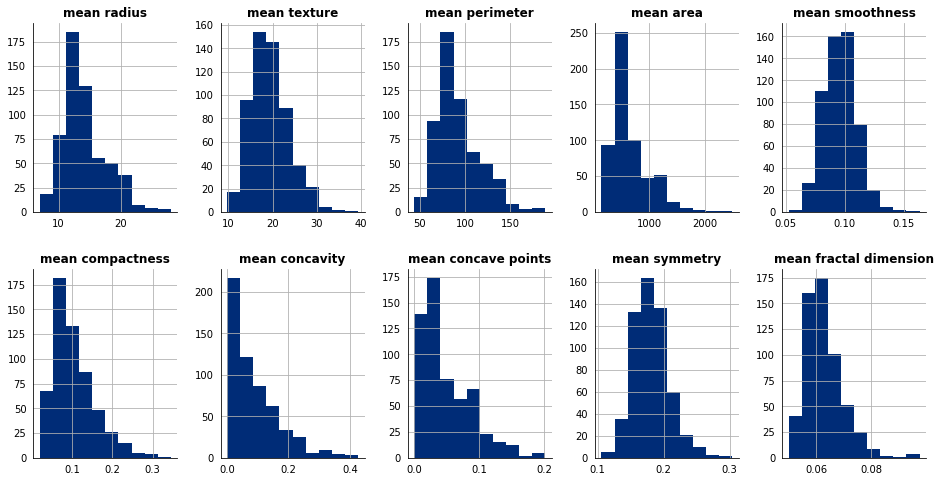

In [7]:
fig, ax = plt.subplots(2,5,figsize=(16, 8))
dataset[mean_variables].hist(ax=ax.flatten()[:10])
plt.show()

Overall, the distribution of the variables are skewed, with fatter right tail. Depending on the relationship to the dependent variable, we may or may not need to transform these variables

<a id="bivariate_exploration"></a>

# Bivariate exploration

This section provides additional exploratory analysis specially useful for classification modeling:
* Correlation analysis and scatter plots for independent variables
* Barplots between categorical dependent variable and each independent variable
* Bivariate plots between binary dependent variable and each independent variable

<a id="correlation_analysis"></a>

## Correlation analysis and scatterplot between independent variables

Correlation analysis provide a measure of the strength of the relationship between two variables, and scatterplots can help visualize them. For categorical variables, these functionalities are not as helpful. Therefore, we focus on the independent variables.

We make use of the .corr() method in pandas, which ignores NaN values for each pair-wise comparison
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html

**Pearson correlation**

In [8]:
with pd.option_context('display.precision', 2):
    plot = dataset[mean_variables].corr(method='pearson').style.background_gradient(cmap='coolwarm')
plot

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension
mean radius,1.000000,0.323782,0.997855,0.987357,0.170581,0.506124,0.676764,0.822529,0.147741,-0.311631
mean texture,0.323782,1.000000,0.329533,0.321086,-0.023389,0.236702,0.302418,0.293464,0.071401,-0.076437
mean perimeter,0.997855,0.329533,1.000000,0.986507,0.207278,0.556936,0.716136,0.850977,0.183027,-0.261477
mean area,0.987357,0.321086,0.986507,1.000000,0.177028,0.498502,0.685983,0.823269,0.151293,-0.283110
mean smoothness,0.170581,-0.023389,0.207278,0.177028,1.000000,0.659123,0.521984,0.553695,0.557775,0.584792
mean compactness,0.506124,0.236702,0.556936,0.498502,0.659123,1.000000,0.883121,0.831135,0.602641,0.565369
mean concavity,0.676764,0.302418,0.716136,0.685983,0.521984,0.883121,1.000000,0.921391,0.500667,0.336783
mean concave points,0.822529,0.293464,0.850977,0.823269,0.553695,0.831135,0.921391,1.000000,0.462497,0.166917
mean symmetry,0.147741,0.071401,0.183027,0.151293,0.557775,0.602641,0.500667,0.462497,1.000000,0.479921
mean fractal dimension,-0.311631,-0.076437,-0.261477,-0.283110,0.584792,0.565369,0.336783,0.166917,0.479921,1.000000


We see here that radius, perimeter, and mean-area are almost perfectly correlated. In the logistic regression, we therefore should only consider one of these variables to avoid multicollinearity.

Number of concave points and concavity are very similar as well. They are also relatively correlated with radius, perimeter, area, and compactness 

**Scatterplots in a matrix grid**

A matrix grid will plot scatterplots for every pair of variables. Given the size of these figures, we can only plot a limited number of variables at once:
* Radius, Perimeter, Area, Compactness, Concavity, Concave Points
* Texture, Smoothness, Compactness, Symmetry, Fractal dimension, and Concave Points (Concave Points represents all the variables in the first plot, given its high correlation to them)

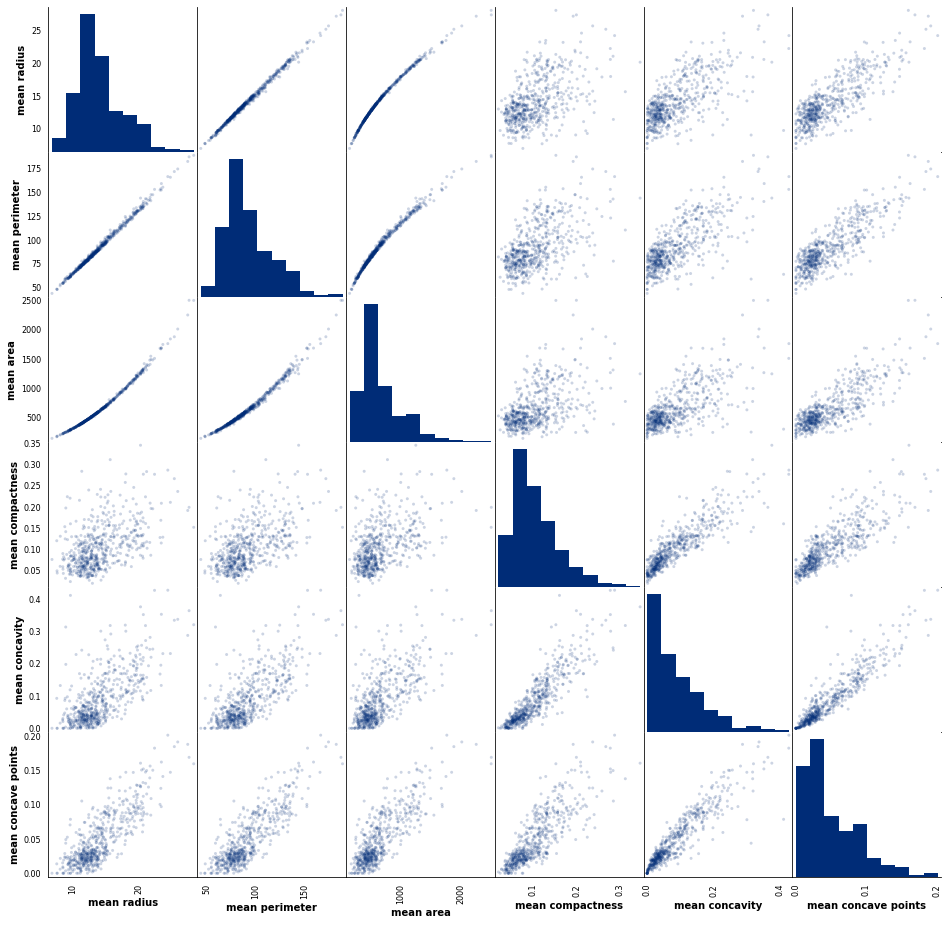

In [9]:
from pandas.plotting import scatter_matrix

first_set = ['mean radius', 'mean perimeter', 'mean area', 'mean compactness', 'mean concavity', 'mean concave points']

_ = scatter_matrix(dataset[first_set], alpha = 0.2, figsize = (16, 16), diagonal = 'hist')

As expected, perimeter and radius are extremely closely correlated (for a circle, they are 100% correlated by definition), have a strong relationship with mean area (for a circle, area is proportional to squared radius).

The relationship among other variables are strong, and near-linear.

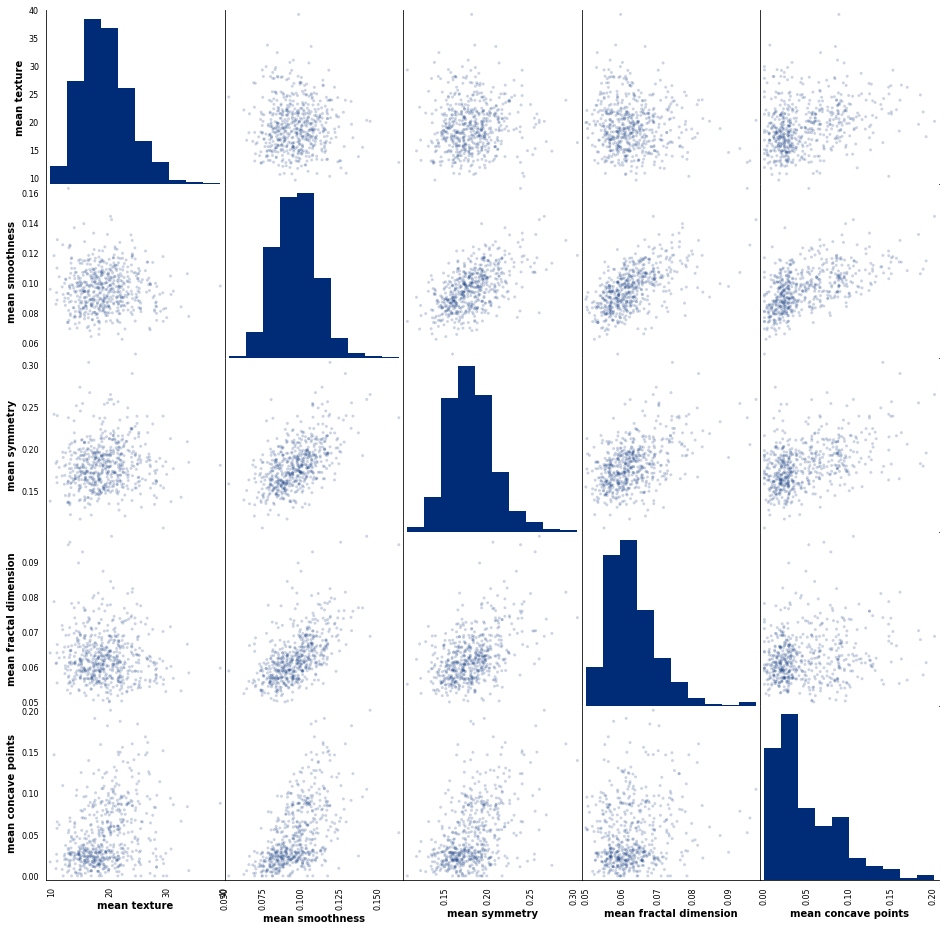

In [10]:
second_set = ['mean texture', 'mean smoothness', 'mean symmetry', 'mean fractal dimension', 'mean concave points']

_ = scatter_matrix(dataset[second_set], alpha = 0.2, figsize = (16, 16), diagonal = 'hist')

Circular blobs are indicative of low or no correlation. There is generally weak correlation.

<a id="barplots"></a>
## Bar-plots to examine relationship between numeric and categorical variables

Here we look at the average independent variable value vs. the target variable. We use groupby to generate the average by target variable value.

In [11]:
average_by_target = dataset.groupby(by=["target"])[mean_variables].mean()

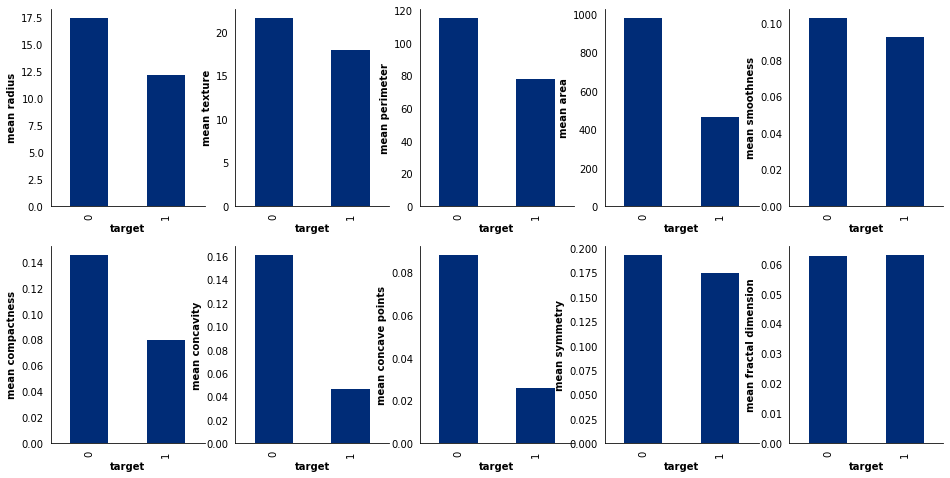

In [12]:
fig, ax = plt.subplots(2, 5, figsize=(16,8))
for idx, col in enumerate(average_by_target.columns):
    average_by_target[col].plot(kind='bar', ax=ax.flatten()[idx], ylabel=col)
plt.show()


**Box and whisker's plot offer more information about the distribution of the independent variable**

Mean value alone may be misleading due to outliers or skewness.

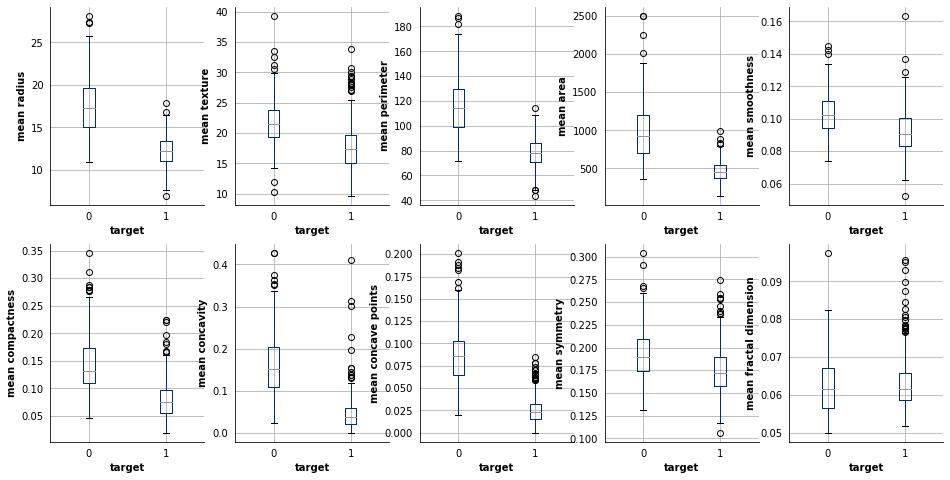

In [13]:
# Box and whisker plot
grouped_data = dataset.groupby("target")[mean_variables]
fig, ax = plt.subplots(2, 5, figsize=(16,8))
for idx, col in enumerate(average_by_target.columns):
    grouped_data.boxplot(ax=ax.flatten()[idx], column=col, subplots=False)
    ax.flat[idx].set(ylabel=col, xticklabels=[0,1], xlabel='target')
plt.show()

<a id="bivariate_plots"></a>
## Bivariate plots

Bivariate plots are great for more closely examining the relationship between a specific independent variable with the dependent (target) variable. In linear models, the assumption is that the dependent variable can be approximated as a linear combination of independent variables, and this typically means that the relationship between each independent variable and the dependent variable is mostly linear. 

(Note: it does not necessarily have to be linear in the 1 vs. 1 relationship, as the independent variable may be correlated with other variables in a multi-factor model)

**Bivariate plots for binary dependent variables**

A regular scatterplot does not make much sense then the dependent variable is binary (e.g. 0 vs. 1) since the plot would consist of a a lot of dots at y = 0 and y = 1, and difficult to discern any patterns. This is shown in the example below

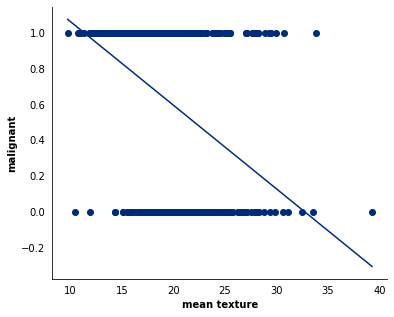

In [14]:
y = dataset['target']
x = dataset['mean texture']

fig, ax = plt.subplots(1,1, figsize=(6,5))
ax.scatter(x, y)
ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x))) # Best fit line
ax.set_xlabel("mean texture")
ax.set_ylabel("malignant")
plt.show()

**By plotting the data at a more aggregated level, the nature of the relationship can be made more clearly**

Here we are using our own function to group the data based on the value of the x-variable (by rank-order), and calculating the average y-value and x-value for the plot. The average y-value is now interpretated as the 'proportion of 1s' or 'probability of malignant' in this example.

For more help on this function, write *help(bivariate_plots.bivariate_continuous)*

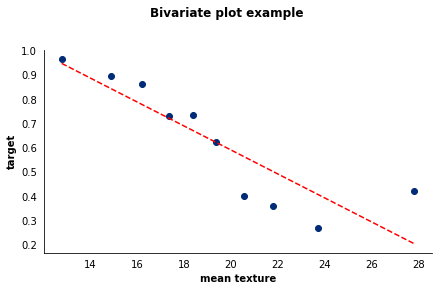

In [15]:
# Basic plot
plot_figure, plot_data = bivariate_plots.bivariate_continuous(used_data = dataset, 
                                                              y_var = "target", x_var = "mean texture", 
                                                              with_count = False, header = "Bivariate plot example",
                                                              trendline = True, num_buckets = 10)

Relation appears linear until texture exceeds about 25 in value. 

Furthermore, note that logistic regression is not directly a linear model. Rather it the linear relationship is for the 'log-odds' of the outcome: If we denote p(x) as the Pr(Malignant|X=x), then the relationship is given by:

logit(p(x)) := ln[p(x)/(1-p(x))] = a+bx    or    p(x) = 1/(1+exp(-a-bx))

Because of this relationship, we may want to transform the y-axis using logit. This can be done by adding the argument: y_scale = 'logit'


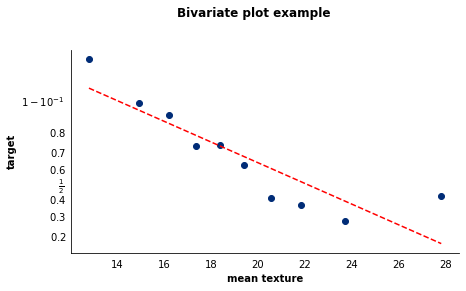

In [16]:
# Logit transformed bivariate plot
plot_figure, plot_data = bivariate_plots.bivariate_continuous(used_data = dataset, 
                                                              y_var = "target", x_var = "mean texture", 
                                                              with_count = False, header = "Bivariate plot example",
                                                              trendline = True, num_buckets = 10, y_scale='logit')

**We create plots for all mean variables**

You have buckets where y-value is 0 or 1 exactly, and these have been bounded to avoid error
You have buckets where y-value is 0 or 1 exactly, and these have been bounded to avoid error
You have buckets where y-value is 0 or 1 exactly, and these have been bounded to avoid error
You have buckets where y-value is 0 or 1 exactly, and these have been bounded to avoid error
You have buckets where y-value is 0 or 1 exactly, and these have been bounded to avoid error


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


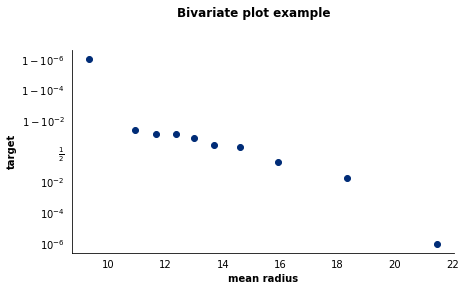

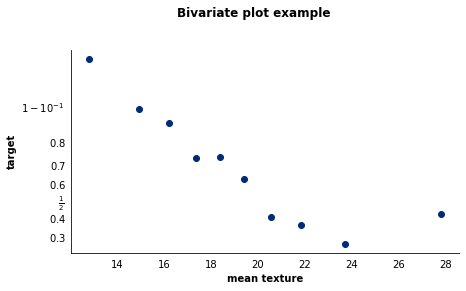

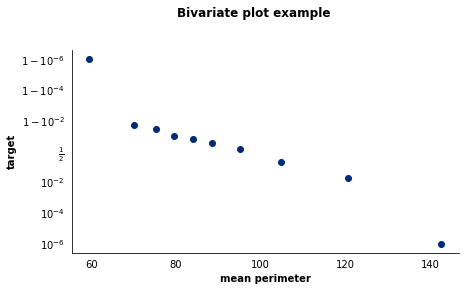

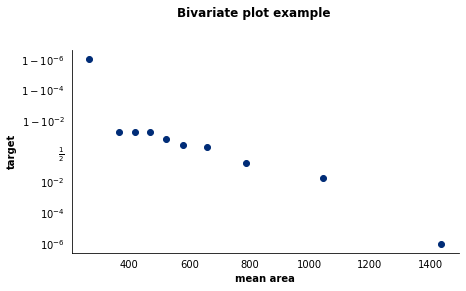

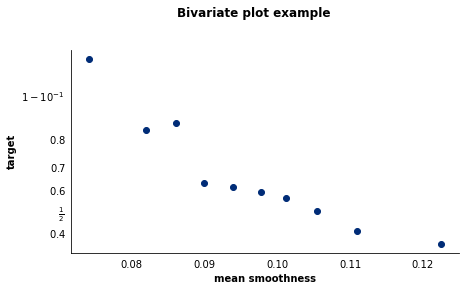

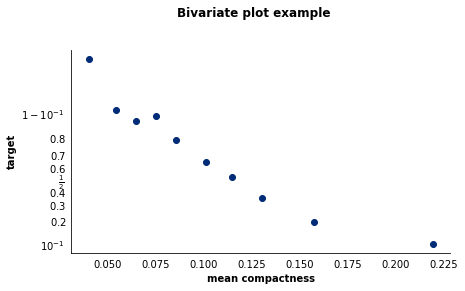

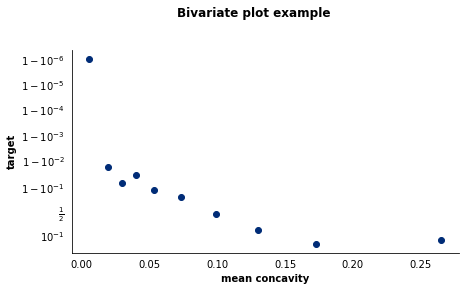

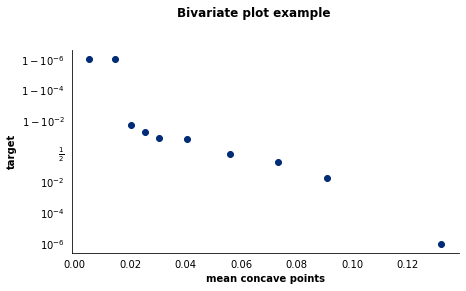

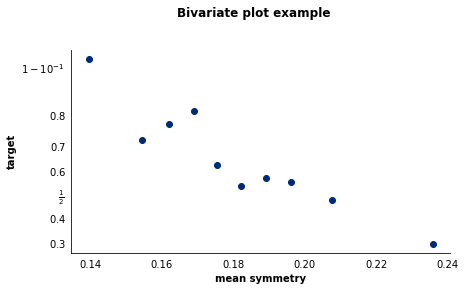

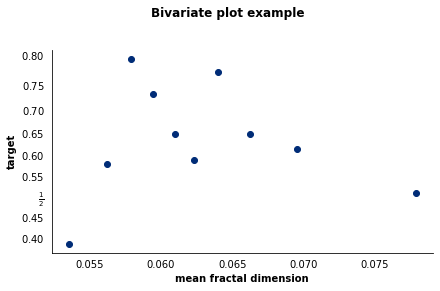

In [17]:
for var in mean_variables:
    plot_figure, plot_data = bivariate_plots.bivariate_continuous(used_data = dataset, 
                                                                  y_var = "target", x_var = var, 
                                                                  with_count = False, header = "Bivariate plot example",
                                                                  trendline = False, num_buckets = 10, y_scale='logit')

When all target variable values for a bucket is 0 or 1, the logit transformation is not defined. Hence, warnings are generated, and the predictions are moved to 0.000001 or 0.999999 in order to be plotted. 

When this occurs, consider whether there may be a structural explanation. In which case, you may wish to segment your data such that a segment is associated with Y = 1 (or Y = 0)  

<a id="data_transformation_train_test_split"></a>
# Data transformations and train-test split

Mean conavity and Mean texture have diminishing impact above a certain level, and we therefore choose to cap them

In [18]:
dataset['mean concavity capped'] = dataset['mean concavity'].clip(lower=None, upper=0.2)
dataset['mean texture capped'] = dataset['mean texture'].clip(lower=None, upper=0.25)

<a id="train_test_split"></a>
## Train-Test split

For model development, it is advisable to split the data into train vs. test, to check that the model has good generalizability. How the train-test split is done should mirror the current data vs. data that the model is expected to be used to predict on. In this case, a random sample of the dataset can be used.

Note that we only included 'radius' out of the set of extremely correlated variables 'radius', 'perimeter', 'area'

In [19]:
all_x_variables =['mean radius', 'mean smoothness', 'mean compactness', 
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'mean concavity capped', 'mean texture capped',
       'mean concavity', 'mean texture']

# This excludes variables that have transformations (i.e. 'mean concavity', 'mean texture')
all_x_variables_transformed =['mean radius', 'mean smoothness', 'mean compactness', 
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'mean concavity capped', 'mean texture capped']

X,y = dataset[all_x_variables], dataset['target']

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.30, random_state=1000)

<a id="feature_selection"></a>
# Feature selection

It is rarely advisable to use all available independent variables in a regression due to risk of overfitting, multicollinearity, and unintuitive model effects. 

There are many ways to identify appropriate subsets of variables for use in a model. Some of these methods are described here:
* Manual selection based on intuition and hypothesis
* Stepwise selection: Beginning with an initial set of variables (potentially no variables, or all variables), consider potential adding / removing of individual independent variables
* Subset selection: Identify many different subsets of variables of different sizes (e.g. 100 2-variable models, 100 3-variable models)
* LASSO regression: Using regularized regression to identify variables

**We build several candidate models in this section, and in the next section analyze and compare these models**  

We use Logistic Regression provided by sklearn: 
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html. To run traditional logistic regression, you need to specify *penalty="none"*. By default, linear_model.LogisticRegression performs a regularized regression, which expected data to be standardized.

<a id="manual_selection_variables"></a>
## Manual selection of variables

In [20]:
manual_variables = ['mean texture capped', "mean concave points"]

manual_model = linear_model.LogisticRegression(penalty="none").fit(X_train[manual_variables], y_train)

<a id="stepwise_selection_variables"></a>
## Stepwise selection using sklearn's feature selection module

This uses the basic functionality offered in sklearn https://scikit-learn.org/stable/modules/feature_selection.html. There is more powerful functionality in mlxtend http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/

In [21]:
lr = linear_model.LogisticRegression(penalty="none")

# Sequential feature selection
sfs = SequentialFeatureSelector(lr, n_features_to_select=5)
sfs.fit(X_train[all_x_variables_transformed], y_train)

stepwise_variables = list(compress(X_train[all_x_variables_transformed], sfs.support_))
stepwise_variables

['mean radius',
 'mean concave points',
 'mean symmetry',
 'mean fractal dimension',
 'mean texture capped']

In [22]:
# Build model with selected features
stepwise_model = lr.fit(X_train[stepwise_variables], y_train)

<a id="subset_selection_variables"></a>
## Subset selection

This approach considers all possible combinations of variables and selects the top K number of each. Note that this can only be run for datasets with a small number of variables to find models with few variables, to avoid the total number of variables from blowing up. This code is adapted from http://www.science.smith.edu/~jcrouser/SDS293/labs/lab8-py.html to work with sklearn

There are more efficient algorithms that do not consider all possible combinations.

In [23]:
def processSubset(training_X, training_Y):
    # Fit model on feature_set and calculate Residual Sum of Squares
    regr = linear_model.LogisticRegression(penalty="none").fit(training_X, training_Y)
    predictions = regr.predict_proba(training_X)[:,1]
    auc = metrics.roc_auc_score(training_Y, predictions)
    return {"model":regr, "Gini":2*auc-1, "Vars":"; ".join(training_X.columns.values), "num_vars": training_X.shape[1]}

def getBest(N_vars, top_models, training_X, training_Y):
    results = []
    for combo in itertools.combinations(training_X.columns, N_vars):
        results.append(processSubset(training_X[list(combo)], training_Y))
    models = pd.DataFrame(results)
    
    # Choose the model with the lowest RSS
    best_models = models.sort_values(["Gini"], ascending=False).head(top_models)
    
    print("Processed", models.shape[0], "models on", N_vars, "predictors")
    
    # Return the best model, along with some other useful information about the model
    return best_models

In [24]:
# Models with 1,2,3 variables, 10 of each

best_models = pd.concat([getBest(n, 10, X_train[all_x_variables_transformed], y_train) for n in [1,2,3]]).reset_index(drop=True)
best_models.sort_values(["Gini"], ascending=False)

Processed 8 models on 1 predictors
Processed 28 models on 2 predictors
Processed 56 models on 3 predictors


,model,Gini,Vars,num_vars
18,LogisticRegression(penalty='none'),0.962273,mean radius; mean smoothness; mean concavity c...,3
19,LogisticRegression(penalty='none'),0.961783,mean radius; mean concave points; mean concavi...,3
20,LogisticRegression(penalty='none'),0.960202,mean radius; mean concave points; mean fractal...,3
21,LogisticRegression(penalty='none'),0.959657,mean radius; mean compactness; mean concave po...,3
22,LogisticRegression(penalty='none'),0.959657,mean radius; mean concave points; mean texture...,3
8,LogisticRegression(penalty='none'),0.959657,mean radius; mean concave points,2
23,LogisticRegression(penalty='none'),0.959602,mean radius; mean concave points; mean symmetry,3
24,LogisticRegression(penalty='none'),0.959384,mean radius; mean smoothness; mean concave points,3
25,LogisticRegression(penalty='none'),0.957530,mean radius; mean compactness; mean concavity ...,3
26,LogisticRegression(penalty='none'),0.957312,mean radius; mean symmetry; mean concavity capped,3


**Select preferred model based on intuition, fit, and complexity**

In [25]:
subsets_variables = ["mean radius", "mean concave points"]
subsets_model = linear_model.LogisticRegression(penalty="none").fit(X_train[subsets_variables], y_train)

<a id="lasso_selection_variables"></a>
## LASSO selection

Regularized regression by penalizing the magnitude of model coefficients on a standardized dataset can be used to remove variables (as the penalty will force coefficients of less important variables to 0)

Here we make use of a wrapper function built around sklearn's LogisticRegression, and it standardizes the data for you so you don't have to pre-standardize. You can find information about this function through *help(lasso_utilities.lasso_logistic)*. 

In [26]:
from regression_classification import model_plots, lasso_utilities, sklearn_regression

lasso_df = lasso_utilities.lasso_logistic(
    dataset=pd.concat([X_train[all_x_variables_transformed], y_train], axis=1),    # Combine X and y data
    DV='target',
    IVs = all_x_variables_transformed,
    forced_in = list(), # No variables to be forced into every model
    intercept = True,
    C_list = [0.0001, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1, 2.5, 5, 7.5, 10, 25]
)

pd.set_option("display.max_colwidth", None)
lasso_df

,C,Variables,Converged?,Gini,Intercept,mean texture capped Coef,mean radius Coef,mean smoothness Coef,mean fractal dimension Coef,mean compactness Coef,mean concavity capped Coef,mean concave points Coef,mean symmetry Coef
0,0.0001,,True,0.000000,0.556547,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.0100,mean radius;mean concavity capped;mean concave points,True,0.936868,0.580956,0.0,-0.050852,0.000000,0.000000,0.000000,-0.030862,-0.454796,0.000000
2,0.0500,mean radius;mean concavity capped;mean concave points,True,0.959002,0.645917,0.0,-1.199264,0.000000,0.000000,0.000000,-0.690890,-0.756472,0.000000
3,0.1000,mean radius;mean concavity capped;mean concave points,True,0.961129,0.600139,0.0,-1.712992,0.000000,0.000000,0.000000,-0.761953,-1.157138,0.000000
4,0.2500,mean radius;mean smoothness;mean concavity capped;mean concave points,True,0.962001,0.575443,0.0,-2.749874,-0.303407,0.000000,0.000000,-1.167479,-0.825062,0.000000
5,0.5000,mean radius;mean smoothness;mean fractal dimension;mean concavity capped;mean concave points;mean symmetry,True,0.962273,0.580865,0.0,-3.193023,-0.553685,0.213617,0.000000,-1.540941,-0.602144,-0.056240
6,0.7500,mean radius;mean smoothness;mean fractal dimension;mean compactness;mean concavity capped;mean concave points;mean symmetry,True,0.962655,0.584422,0.0,-3.293242,-0.657839,0.377104,0.010335,-1.727950,-0.585600,-0.090916
7,1.0000,mean radius;mean smoothness;mean fractal dimension;mean compactness;mean concavity capped;mean concave points;mean symmetry,True,0.962928,0.567972,0.0,-3.283626,-0.631438,0.396535,0.037199,-1.671343,-0.819475,-0.126729
8,2.5000,mean radius;mean smoothness;mean fractal dimension;mean compactness;mean concavity capped;mean concave points;mean symmetry,True,0.964182,0.558780,0.0,-3.582534,-0.798949,0.384307,0.468215,-2.167314,-0.609033,-0.159445
9,5.0000,mean radius;mean smoothness;mean fractal dimension;mean compactness;mean concavity capped;mean concave points;mean symmetry,True,0.965654,0.540351,0.0,-4.247522,-1.038652,0.098398,1.068352,-2.662115,-0.240262,-0.155372


**We select a model where Gini does not materially improve with the number of additional variables added**

Index 2 appears like a good model. Below, we select the models and retrain an logistic regression. (An alternative would be to stick with the regularized logistic regression itself, which will be slightly different from the logistic regression)

In [27]:
lasso_variables = lasso_df.loc[2,'Variables'].split(';')
lasso_model = linear_model.LogisticRegression(penalty="none").fit(X_train[lasso_variables], y_train)
lasso_variables

['mean radius', 'mean concavity capped', 'mean concave points']

<a id="analyze_models"></a>
# Analyze models

This calculates key performance statistics for each model, and for a selected model provides further deepdives.

<a id="model_performance_statistics"></a>
## Model performance statistics

Gini, McFadden's R2, KS statistics. Many metrics are covered here: https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics

McFadden's R2 is a pseudo-Rsquared metric: https://datascience.oneoffcoder.com/psuedo-r-squared-logistic-regression.html 


Many classification metrics such as accuracy score require a class prediction (i.e. prediction that is 0 or 1, rather than the probability). This requires selection of a probability threshold for determining whether a prediction should be 0 or 1, and the choice is not necessarily 50%. Hence we have left those metrics out.

In [28]:
def get_stats(regression, X, y, scores = ["gini", "mcfadden_r2", "ks"]):
    
    predictions = regression.predict_proba(X)[:,1]
    results = {}
    
    results['variables'] = "; ".join(X.columns.values)
    if "gini" in scores:
        results['gini'] = 2 * metrics.roc_auc_score(y_true = y, y_score = predictions) - 1
    if "mcfadden_r2" in scores:
        results['mcfadden_r2'] = 1 - metrics.log_loss(y, predictions) / metrics.log_loss(y, [np.mean(y)] * len(y))
    if "ks" in scores:
        results['ks'] = sc.stats.ks_2samp(predictions[y==1], predictions[y!=1]).statistic
        
    return results
        

**Generate performance statistics for train**

In [29]:
train_stats = pd.DataFrame({
    "manual": get_stats(manual_model, X_train[manual_variables], y_train),
    "stepwise": get_stats(stepwise_model, X_train[stepwise_variables], y_train),
    "subsets": get_stats(subsets_model, X_train[subsets_variables], y_train),
    "lasso": get_stats(lasso_model, X_train[lasso_variables], y_train),  
}).T
train_stats

,variables,gini,mcfadden_r2,ks
manual,mean texture capped; mean concave points,0.925147,0.642322,0.813548
stepwise,mean radius; mean concave points; mean symmetry; mean fractal dimension; mean texture capped,0.959657,0.743457,0.853073
subsets,mean radius; mean concave points,0.959657,0.741349,0.858961
lasso,mean radius; mean concavity capped; mean concave points,0.961783,0.750239,0.860815


**Generate performance statistics for test data**

In [30]:
test_stats = pd.DataFrame({
    "manual": get_stats(manual_model, X_test[manual_variables], y_test),
    "stepwise": get_stats(stepwise_model, X_test[stepwise_variables], y_test),
    "subsets": get_stats(subsets_model, X_test[subsets_variables], y_test),
    "lasso": get_stats(lasso_model, X_test[lasso_variables], y_test),  
}).T
test_stats

,variables,gini,mcfadden_r2,ks
manual,mean texture capped; mean concave points,0.932692,0.684338,0.872991
stepwise,mean radius; mean concave points; mean symmetry; mean fractal dimension; mean texture capped,0.951493,0.639657,0.839839
subsets,mean radius; mean concave points,0.952067,0.640047,0.839839
lasso,mean radius; mean concavity capped; mean concave points,0.953502,0.647465,0.8219


Overall, we would like to have a model with good insample and out-of-sample performance (deterioration in out of sample would indicate that the model is overfitted or fails in generalizing), intuitive variables and coefficient signs, and is not unnecessarily complex. 

**A potential candidate is the lasso regression here. So we examine it further below.**

Model coefficients:

In [31]:
print("Intercept: {}".format(lasso_model.intercept_))
coefficients = pd.DataFrame(dict(zip(lasso_variables, lasso_model.coef_[0])), index=[0])
coefficients

Intercept: [18.87016704]


,mean radius,mean concavity capped,mean concave points
0,-1.020221,-19.372861,-52.949996


<a id="model_performance_plots"></a>
## Model performance plots

We look at a few different plots here:
* ROC plot, histogram plot of predictions. There are additional plotting functionality in a library called 'scikit-plot': https://scikit-plot.readthedocs.io/en/stable/metrics.html
* Average vs. Predicted plot
* Average and Predicted values by x-variable
* Average and Predicted values by other intuitive variables not in the model

**ROC plot**

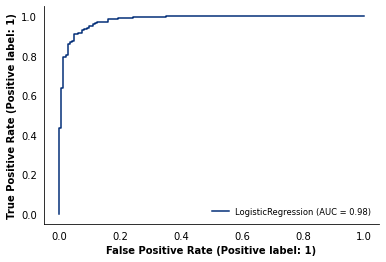

In [32]:
# Train data
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(lasso_model, X_train[lasso_variables], y_train)
plt.show()

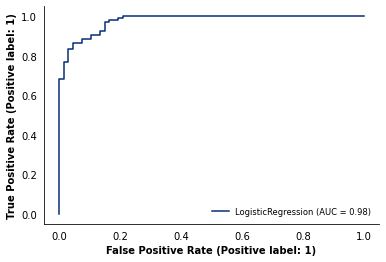

In [33]:
# Test data
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(lasso_model, X_test[lasso_variables], y_test)
plt.show()

**Histogram plots**

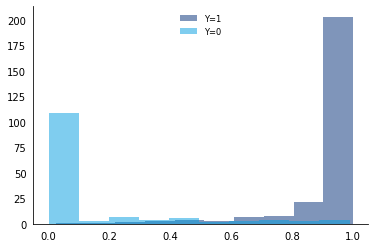

In [34]:
# Train data
pred_train = lasso_model.predict_proba(X_train[lasso_variables])[:,1]

plt.hist(pred_train[y_train.values==1], 
         alpha=0.5, # the transaparency parameter
         label='Y=1')
  
plt.hist(pred_train[y_train.values==0],
         alpha=0.5,
         label='Y=0')
  
plt.legend(loc='upper center')
plt.show()

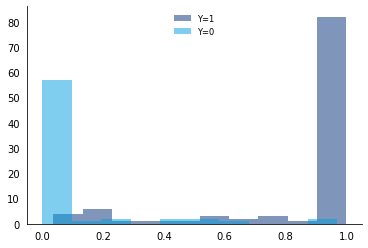

In [35]:
# Test data
pred_train = lasso_model.predict_proba(X_test[lasso_variables])[:,1]

plt.hist(pred_train[y_test.values==1], 
         alpha=0.5, # the transaparency parameter
         label='Y=1')
  
plt.hist(pred_train[y_test.values==0],
         alpha=0.5,
         label='Y=0')
  
plt.legend(loc='upper center')
plt.show()

**Add predictions to dataframe containing X and y data**

In [36]:
train_data = pd.concat([X_train, y_train], axis=1)
train_data['lasso_prediction'] = lasso_model.predict_proba(X_train[lasso_variables])[:,1]

**Average vs. Predicted Plot**

This plot groups the data based on the predicted value, from low to high, and calculates the average actual and predicted value for each group. A strong model would fall on the 45 degree line in this chart, as that means the model is not biased for various ranges of predictions.

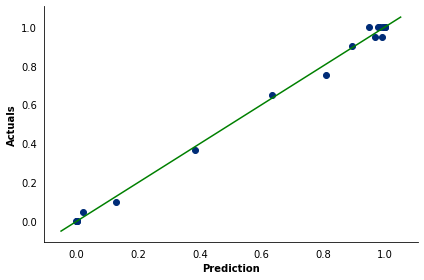

In [37]:
fig, plotdata = model_plots.act_vs_pred_plot(used_data = train_data, 
                             actual_var = 'target', 
                             pred_var = "lasso_prediction", 
                             num_buckets = 20, with_count = False)

The number of bins can also be modified, to get a sense of the variance in the predictions, with the extreme being the same as a scatter plot

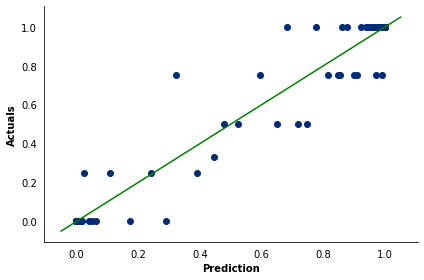

In [38]:
fig, plotdata = model_plots.act_vs_pred_plot(used_data = train_data, 
                             actual_var = 'target', 
                             pred_var = "lasso_prediction", 
                             num_buckets = 100, with_count = False)

**Average and Predicted values by x-variable**

This groups the data based on a provided x-variable value, from low to high, and calculates the average actual (blue) and average predicted (red) for each bucket. A good model would have similar model errors throughout the x-variable values. If the actual vs. predicted values start to trail off, that may mean that a data transformation is necessary

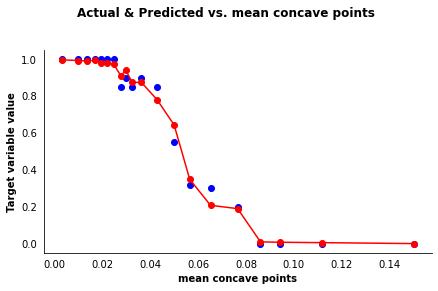

In [39]:
fig, plotdata = model_plots.model_comparison_continuous(used_data = train_data, 
                                                        actual_var = "target", 
                                                        pred_var = "lasso_prediction", 
                                                        x_var = "mean concave points", 
                                                        num_buckets=20, 
                                                        with_count = False)

**While the model used 'mean concavity capped', we can still plot 'mean concavity' on the x-axis to confirm that the transformation worked well**

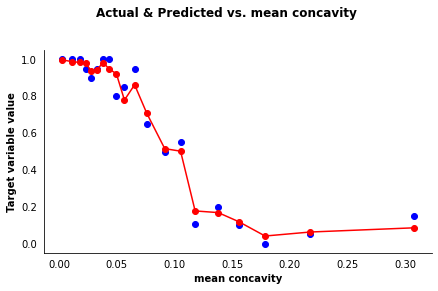

In [40]:
fig, plotdata = model_plots.model_comparison_continuous(used_data = train_data, 
                                                        actual_var = "target", 
                                                        pred_var = "lasso_prediction", 
                                                        x_var = "mean concavity", 
                                                        num_buckets=20, 
                                                        with_count = False)

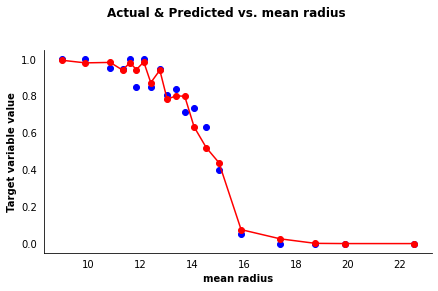

In [41]:
fig, plotdata = model_plots.model_comparison_continuous(used_data = train_data, 
                                                        actual_var = "target", 
                                                        pred_var = "lasso_prediction", 
                                                        x_var = "mean radius", 
                                                        num_buckets=20, 
                                                        with_count = False)

**Overall, the model predictions appear reasonable for all models, without resulting in large errors even for the smallest or largest x-variables**

**Average and Predicted values by variable not in the model**

This groups the data based on the value of an intuitive x-variable not in the model, from low to high, and calculates the average actual (blue) and average predicted (red) for each bucket. A good model is expected to perform well across this x-variable, as the relationship should be implicitly captured by other variables that are included in the model. If the model does not perform well, it may indicate that this x-variable should in some form be included in the model


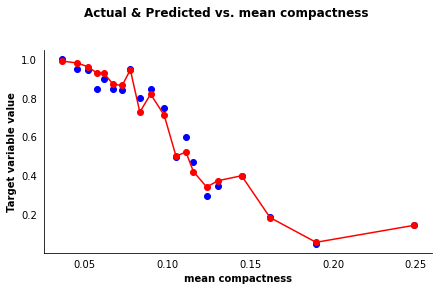

In [42]:
fig, plotdata = model_plots.model_comparison_continuous(used_data = train_data, 
                                                        actual_var = "target", 
                                                        pred_var = "lasso_prediction", 
                                                        x_var = "mean compactness", 
                                                        num_buckets=20, 
                                                        with_count = False)

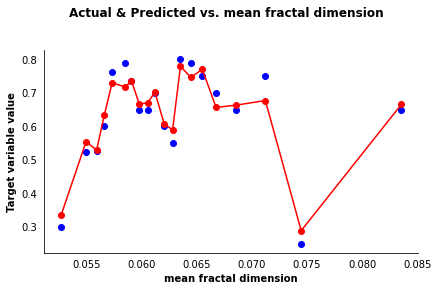

In [43]:
fig, plotdata = model_plots.model_comparison_continuous(used_data = train_data, 
                                                        actual_var = "target", 
                                                        pred_var = "lasso_prediction", 
                                                        x_var = "mean fractal dimension", 
                                                        num_buckets=20, 
                                                        with_count = False)

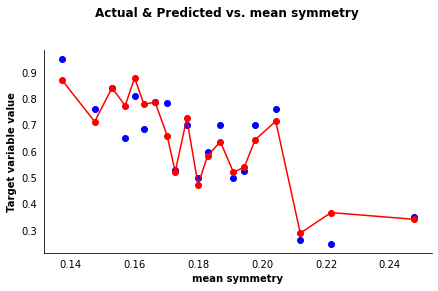

In [44]:
fig, plotdata = model_plots.model_comparison_continuous(used_data = train_data, 
                                                        actual_var = "target", 
                                                        pred_var = "lasso_prediction", 
                                                        x_var = "mean symmetry", 
                                                        num_buckets=20, 
                                                        with_count = False)

**None of the three x-variables above are in the model, yet the model captures the correlation with these variables** 

<a id="model_inference"></a>
## Model inference (p-values)

sklearn's regressions do not produce p-values for the coefficients. While we have built a module for generating p-values for GLM models dependent on Sklearn regression, it is not applicable for binary dependent variables.

Instead, we recommend using statsmodels!

**If you had statsmodels, you would run the following**

In [45]:
# import statsmodels.api as sm
# X_train['intercept'] = 1
# statsmodel = sm.Logit(y_train, X_train[['intercept']+lasso_variables]).fit()
# print(statsmodel.summary())